## Import essential libraies

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Download dataset

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

## Extract dataset in local space

In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

## Explore the dataset structure

In [4]:
def show_folders(path):
  data_dir = path
  print(os.listdir(data_dir))
  classes = os.listdir(data_dir + "/train")
  print(classes)

show_folders('./data/cifar10')

['test', 'train']
['bird', 'truck', 'airplane', 'cat', 'ship', 'frog', 'automobile', 'horse', 'deer', 'dog']


## Explore some images

In [5]:
data_dir = './data/cifar10'

In [6]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Label:  airplane (0)


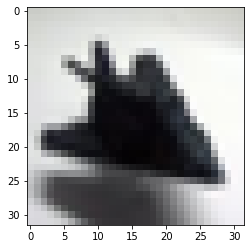

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])

## Train Val Test split

In [8]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [9]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

## Model

In [10]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images) #Generate prediction
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
  
  
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




In [11]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))
    
  def forward(self, xb):
    return self.network(xb)

In [12]:
model = Cifar10CnnModel()

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        cnt=0
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            cnt+=1
        print(cnt)
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [21]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

352
Epoch [0], train_loss: 1.7494, val_loss: 1.3660, val_acc: 0.4873
352
Epoch [1], train_loss: 1.2090, val_loss: 1.0765, val_acc: 0.6030
352
Epoch [2], train_loss: 0.9291, val_loss: 0.9240, val_acc: 0.6735
352
Epoch [3], train_loss: 0.7609, val_loss: 0.7973, val_acc: 0.7253
352
Epoch [4], train_loss: 0.6215, val_loss: 0.7488, val_acc: 0.7482
352
Epoch [5], train_loss: 0.5026, val_loss: 0.7138, val_acc: 0.7682
352
Epoch [6], train_loss: 0.4025, val_loss: 0.7369, val_acc: 0.7589
352
Epoch [7], train_loss: 0.3018, val_loss: 0.7507, val_acc: 0.7728
352
Epoch [8], train_loss: 0.2411, val_loss: 0.8559, val_acc: 0.7677
352
Epoch [9], train_loss: 0.1795, val_loss: 0.9692, val_acc: 0.7539


## Test

In [22]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: automobile , Predicted: automobile


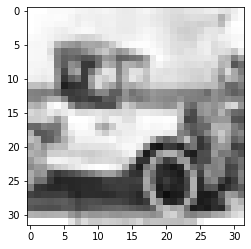

In [27]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [28]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.75439453125, 'val_loss': 0.9749872088432312}

## saving the model

In [29]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [30]:
model2 = to_device(Cifar10CnnModel(), device)

In [31]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [32]:
evaluate(model2, test_loader)

{'val_acc': 0.75439453125, 'val_loss': 0.9749872088432312}

In [34]:
evaluate(model, test_loader) == evaluate(model2, test_loader)

True